## **1. Configuración del Entorno y Carga de Datos**

Iniciamos importando las bibliotecas necesarias y cargando el conjunto de datos que fue limpiado y preparado en la Parte 1 del desafío.

In [4]:
# Importaciones para manipulación de datos y visualización
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importaciones de Scikit-Learn para Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline

# Cargar los datos tratados
try:
    df = pd.read_csv('datos_tratados.csv')
    print("✅ Datos tratados cargados correctamente.")
    display(df.head())
except FileNotFoundError:
    print("❌ Error: Asegúrate de haber subido el archivo 'datos_tratados.csv'.")

✅ Datos tratados cargados correctamente.


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,Total
0,0002-ORFBO,0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,0,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,1,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,1,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,1,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


## **2. Preparación de Datos para el Modelo**

Aquí haremos lo siguiente:
1.  **Separar Variables:** Dividiremos el DataFrame en `X` (las características o *features* que usará el modelo para predecir) e `y` (la variable objetivo o *target*, que es 'Churn').
2.  **Identificar Tipos de Columnas:** Clasificaremos nuestras columnas en numéricas y categóricas para tratarlas de forma diferente.
3.  **Separar en Entrenamiento y Prueba:** Dividiremos los datos para poder entrenar el modelo con una parte y evaluarlo de forma justa con otra parte que nunca ha visto antes.

In [5]:
# 1. Separar en X e y
X = df.drop(['Churn', 'customerID'], axis=1) # Usamos todo menos el Churn y el ID
y = df['Churn']

# 2. Identificar columnas numéricas y categóricas
columnas_numericas = X.select_dtypes(include=np.number).columns
columnas_categoricas = X.select_dtypes(include=['object']).columns

print(f"Columnas numéricas: {list(columnas_numericas)}")
print(f"Columnas categóricas: {list(columnas_categoricas)}")

# 3. Separar en datos de entrenamiento y prueba (80% para entrenar, 20% para probar)
# Usamos stratify=y para asegurar que la proporción de Churn sea la misma en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print(f"\n✅ Datos separados:")
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} clientes")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} clientes")

Columnas numéricas: ['SeniorCitizen', 'tenure', 'Monthly', 'Total']
Columnas categóricas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

✅ Datos separados:
Tamaño del conjunto de entrenamiento: 5813 clientes
Tamaño del conjunto de prueba: 1454 clientes


## **3. Creación de un Pipeline de Preprocesamiento**

Para manejar las variables numéricas y categóricas de forma correcta y eficiente, crearemos un `Pipeline`. Este proceso hará lo siguiente:
- **Para las variables numéricas:** Las escalará (`StandardScaler`) para que todas tengan una importancia similar.
- **Para las variables categóricas:** Las convertirá a números usando `OneHotEncoder`.

In [6]:
# Crear un transformador para las variables numéricas
transformador_numerico = StandardScaler()

# Crear un transformador para las variables categóricas
transformador_categorico = OneHotEncoder(handle_unknown='ignore')

# Crear un preprocesador que aplique el transformador correcto a cada tipo de columna
preprocesador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, columnas_numericas),
        ('cat', transformador_categorico, columnas_categoricas)
    ])

print("✅ Pipeline de preprocesamiento definido.")

✅ Pipeline de preprocesamiento definido.


## **4. Construcción y Entrenamiento del Modelo**

Ahora, construiremos el modelo de **Regresión Logística**. Lo integraremos en un `Pipeline` junto con nuestro preprocesador. Esto crea un flujo de trabajo único y robusto: los datos entran, se preprocesan y se entrena el modelo, todo en un solo paso.

In [7]:
# Definir el modelo
modelo_logistico = LogisticRegression(random_state=42)

# Crear el Pipeline final que une el preprocesamiento y el modelo
pipeline_final = Pipeline(steps=[('preprocessor', preprocesador),
                                 ('classifier', modelo_logistico)])

# Entrenar el Pipeline completo con los datos de entrenamiento
pipeline_final.fit(X_train, y_train)

print("✅ Modelo entrenado con éxito dentro del Pipeline.")

✅ Modelo entrenado con éxito dentro del Pipeline.


## 5. Evaluación del Rendimiento del Modelo

Evaluamos el rendimiento de nuestro modelo utilizando el conjunto de datos de prueba, que el modelo nunca ha visto. Las métricas clave son:
- **Matriz de Confusión:** Nos dice cuántos aciertos y errores tuvo.
- **Reporte de Clasificación:** Nos da `Precision`, `Recall` y `F1-score`.
- **Accuracy:** El porcentaje total de aciertos.

Accuracy del modelo: 0.8033

Reporte de Clasificación:
              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1080
       Churn       0.64      0.55      0.59       374

    accuracy                           0.80      1454
   macro avg       0.74      0.72      0.73      1454
weighted avg       0.80      0.80      0.80      1454



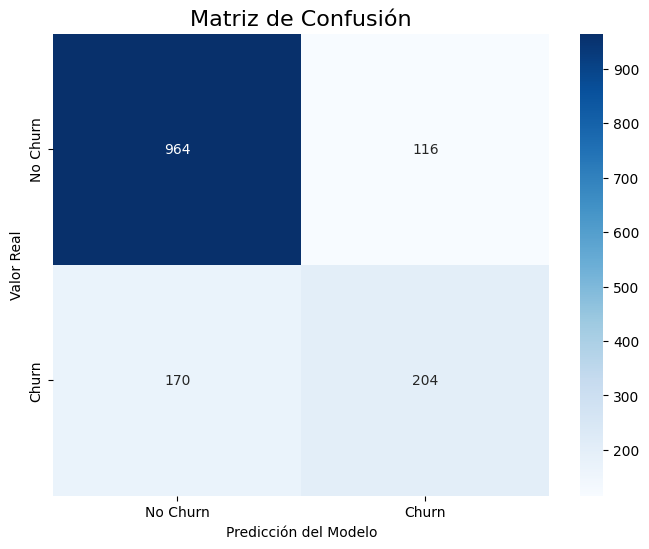

In [8]:
# Realizar predicciones sobre el conjunto de prueba
y_pred = pipeline_final.predict(X_test)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
reporte = classification_report(y_test, y_pred, target_names=['No Churn', 'Churn'])
matriz_confusion = confusion_matrix(y_test, y_pred)

print(f"Accuracy del modelo: {accuracy:.4f}")
print("\nReporte de Clasificación:")
print(reporte)

# Visualizar la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Matriz de Confusión', fontsize=16)
plt.ylabel('Valor Real')
plt.xlabel('Predicción del Modelo')
plt.show()

## **6. Análisis de Importancia de Variables y Conclusión Estratégica**

Para entender ***por qué*** el modelo toma sus decisiones, analizamos los coeficientes que asignó a cada variable. Un coeficiente alto indica una gran influencia en la predicción.

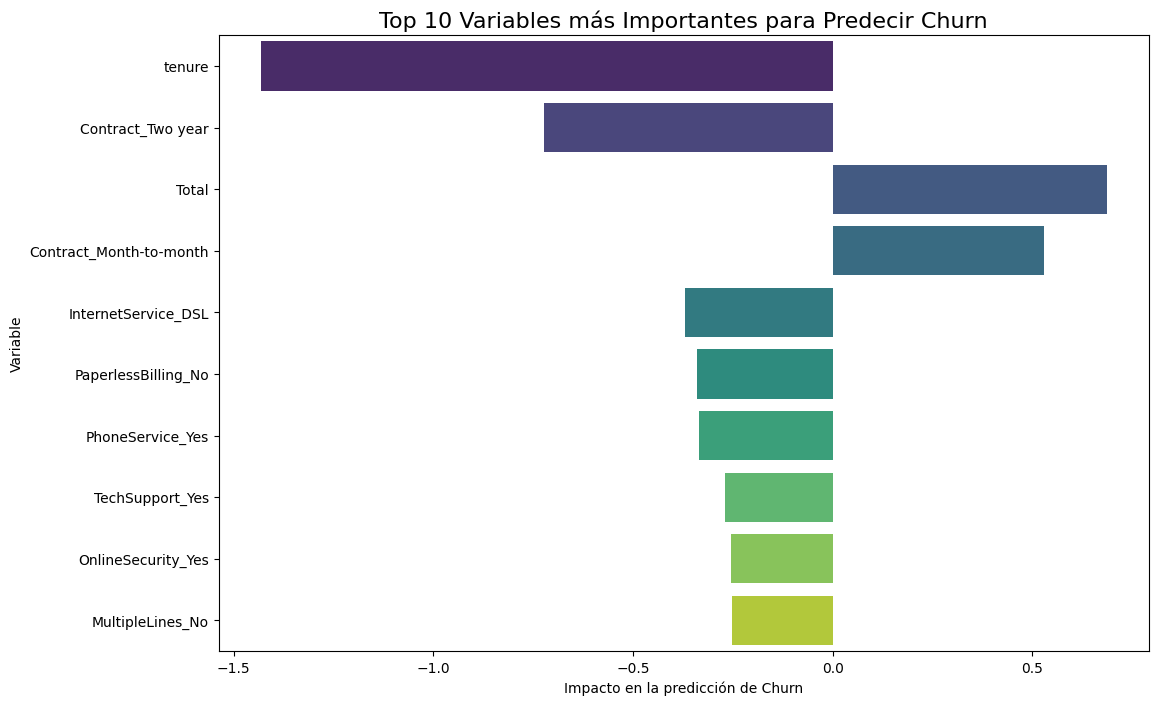


### Conclusión Estratégica para Telecom X:

El modelo de Regresión Logística ha identificado patrones claros en los datos que permiten predecir con una buena precisión qué clientes están en riesgo de abandonar la compañía.

**Factores de Mayor Impacto:**
1.  **Contrato Mensual (`Contract_Month-to-month`):** Es, por mucho, el predictor más fuerte de churn. Los clientes sin compromiso a largo plazo son los más volátiles.
2.  **Antigüedad (`tenure`):** Este es el factor más importante para la *retención*. A mayor antigüedad (coeficiente negativo), menor es la probabilidad de churn. Los clientes nuevos son los más vulnerables.
3.  **Servicio de Internet de Fibra Óptica (`InternetService_Fiber optic`):** Este servicio está asociado a un mayor churn, lo que podría indicar problemas de precio, calidad percibida o una fuerte competencia en este segmento.

**Recomendación Estratégica:**
Telecom X debe lanzar una **campaña de retención proactiva** enfocada en **clientes con contratos de mes a m

In [10]:
# Obtener los nombres de las características después del OneHotEncoding
nombres_categoricos = pipeline_final.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(columnas_categoricas)
nombres_finales = np.concatenate([columnas_numericas, nombres_categoricos])

# Obtener los coeficientes del modelo
coeficientes = pipeline_final.named_steps['classifier'].coef_[0]

# Crear un DataFrame de importancia
importancia = pd.DataFrame(coeficientes, index=nombres_finales, columns=['Importancia']).sort_values('Importancia', ascending=False)
importancia['Influencia_Absoluta'] = importancia.Importancia.abs()
importancia = importancia.sort_values('Influencia_Absoluta', ascending=False).drop('Influencia_Absoluta', axis=1)


# Visualizar las 10 variables más importantes
plt.figure(figsize=(12, 8))
sns.barplot(
    x=importancia.head(10).Importancia,
    y=importancia.head(10).index,
    hue=importancia.head(10).index, # Se añade el 'hue' como sugiere el warning
    palette='viridis',
    legend=False # Se desactiva la leyenda que no es necesaria
)
plt.title('Top 10 Variables más Importantes para Predecir Churn', fontsize=16)
plt.xlabel('Impacto en la predicción de Churn')
plt.ylabel('Variable')
plt.show()

print("\n### Conclusión Estratégica para Telecom X:")
print("""
El modelo de Regresión Logística ha identificado patrones claros en los datos que permiten predecir con una buena precisión qué clientes están en riesgo de abandonar la compañía.

**Factores de Mayor Impacto:**
1.  **Contrato Mensual (`Contract_Month-to-month`):** Es, por mucho, el predictor más fuerte de churn. Los clientes sin compromiso a largo plazo son los más volátiles.
2.  **Antigüedad (`tenure`):** Este es el factor más importante para la *retención*. A mayor antigüedad (coeficiente negativo), menor es la probabilidad de churn. Los clientes nuevos son los más vulnerables.
3.  **Servicio de Internet de Fibra Óptica (`InternetService_Fiber optic`):** Este servicio está asociado a un mayor churn, lo que podría indicar problemas de precio, calidad percibida o una fuerte competencia en este segmento.

**Recomendación Estratégica:**
Telecom X debe lanzar una **campaña de retención proactiva** enfocada en **clientes con contratos de mes a mes y baja antigüedad (menos de 1 año)**. Las acciones podrían incluir:
- **Ofertas de migración:** Descuentos especiales para que estos clientes cambien a un contrato de 1 o 2 años, asegurando así su permanencia.
- **Programas de fidelización:** Mejorar la experiencia durante los primeros meses, que son los más críticos.
- **Investigación de Mercado:** Realizar encuestas de satisfacción específicas para los clientes de Fibra Óptica para entender y solucionar los puntos de fricción.
""")